In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0-preview is required
import tensorflow
assert tensorflow.__version__ >= "2.0"

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,BatchNormalization,InputLayer,Layer,Conv2D,MaxPooling2D,Dense,Dropout,Activation,Flatten,Lambda,Reshape,Concatenate,concatenate

from tensorflow.keras import backend as K

import pypianoroll
from pypianoroll import Multitrack, Track

In [2]:
def toPypianoroll(created_music, music_index, pypianoroll_musics):
    music = pypianoroll_musics[music_index]
    tempo = music.tempo[0:10]
    downbeat = music.downbeat[0:10]
    beat_resolution = music.beat_resolution
    name = music.name
    
    pypianoroll_music = Track(pianoroll = created_music, program=0, is_drum=False,
              name='Guitar')
    
    return Multitrack(tracks = [pypianoroll_music], tempo = tempo, downbeat = downbeat,
        beat_resolution = beat_resolution, name = name)

In [3]:
def formatSongs(musics):
    for m in musics:
        m.pianoroll = np.array(m.pianoroll[384:1344,:]) # faixa de steps para Nº compassos == 10

In [4]:
def rounded_accuracy(y_true, y_pred):
    return tensorflow.keras.metrics.binary_accuracy(tensorflow.round(y_true), tensorflow.round(y_pred))

In [5]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1] == self.units
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = Activation(self.activation)(output)
        return output


In [6]:
music_files = []

for root, subFolders, files in os.walk(os.path.realpath("D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Extraida\lpd_5")):
    if files:
        music_files.append(root + "/" + files[0])

In [7]:
_range = 2500
pypianoroll_musics = []

for music in music_files[:_range]:
    pypianoroll_musics.append(pypianoroll.load(music))

In [8]:
guitar_tracks = []
tempo_song = [] # to rebuild midi file, with Multitrack API from Pypianoroll

for music in pypianoroll_musics:
    for track in music.tracks:
        if track.name == 'Guitar':
            if len(track.pianoroll) > 0: 
                guitar_tracks.append(track) 
                tempo_song.append(music.tempo)
                
formatSongs(guitar_tracks)


In [9]:
compasses_array = []
for track in guitar_tracks:
    Tamanho_diferente=0
    music = track.pianoroll
    compass_array = []
    for compass in range(10):
        left_limit = 96 * compass
        right_limit = 96 + 96 * compass
        if (len(music[left_limit : right_limit])==96):
            compass_array.append(music[left_limit : right_limit])
        if (len(music[left_limit : right_limit])<96):
            Tamanho_diferente+=1
    if (Tamanho_diferente==0):       
        compasses_array.append(compass_array)
print(len(guitar_tracks))
print(len(compasses_array))
print(Tamanho_diferente)

1707
1706
0


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(compasses_array, compasses_array, test_size=0.1, random_state=42)


In [11]:
compasses_array = np.array(compasses_array)
print (compasses_array.shape)

X_train = np.array(X_train)
print (X_train.shape)

X_test = np.array(X_test)
print (X_test.shape)


(1706, 10, 96, 128)
(1535, 10, 96, 128)
(171, 10, 96, 128)


In [12]:
Compassos=[]
Entrada = Input(shape=(10,96,128))
Densa_Inicial =  Dense(40,kernel_regularizer=tensorflow.keras.regularizers.l2(0.01))
for k in range(10):
    Entrada_Crop = Lambda(lambda x: x[:,k,:,:])(Entrada)
    Flat = Flatten()(Entrada_Crop)
    Densa = Densa_Inicial(Flat)
    #Batch_1 = BatchNormalization(momentum=0.7)(Densa)
    Act_1 = Activation('selu')(Densa)
    Drop_1 = Dropout(0.3)(Act_1)
    Compassos.append(Drop_1) 

Conc = Concatenate()(Compassos)

Densa_Meio  = Dense(40,kernel_regularizer=tensorflow.keras.regularizers.l2(0.01))

Encoder = Densa_Meio(Conc)
#Batch_2 = BatchNormalization(momentum=0.9)(Encoder)
Act_2 = Activation('selu')(Encoder)
Drop_2 = Dropout(0.3)(Act_2) 

In [41]:
#Decoder = DenseTransposeGrande(Encoder)
Decoder = DenseTied(400, tied_to = Densa_Meio, use_bias=False)(Drop_2)
#Batch_3 = BatchNormalization(momentum=0.7)(Decoder)
Act_3 = Activation('selu')(Decoder)
Drop_3 = Dropout(0.3)(Act_3)

Densa_Final = DenseTied(12288, tied_to = Densa_Inicial, use_bias=False)

Decoders=[]
for k in range(10):
    Decoders_Crop = Lambda(lambda x: x[:,k*40:(k+1)*40])(Drop_3)
    Decoders_Dense = Densa_Final(Decoders_Crop)
    #Batch_Fim = BatchNormalization(momentum=0.9)(Decoders_Dense)
    Act_Fim = Activation('sigmoid')(Decoders_Dense)
    Drop_Fim = Dropout(0.3)(Act_Fim)
    Reshaping =  Reshape((1,96, 128))(Drop_Fim)
    Decoders.append(Reshaping) 
    
Conc_Final = Concatenate(axis = 1)(Decoders)
Final = Lambda(lambda x: x*100)(Conc_Final)


In [42]:
model = tensorflow.keras.models.Model(inputs = [Entrada], outputs = [Final])
model.compile(loss="binary_crossentropy", # depends on what you care most about
              optimizer = "adam", metrics=["accuracy"])
model.build([])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 96, 128) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 96, 128)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96, 128)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 96, 128)      0           input_1[0][0]                    
____________________________________________________________________________________________

In [43]:
history = model.fit(compasses_array, compasses_array, epochs=20)

Epoch 1/20
1706/1706 [==============================] - 11s 7ms/sample - loss: -0.6677 - accuracy: 0.8806
Epoch 2/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.2681 - accuracy: 0.8634
Epoch 3/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.4044 - accuracy: 0.86585s - loss
Epoch 4/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.3830 - accuracy: 0.8626
Epoch 5/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.4566 - accuracy: 0.8582
Epoch 6/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.1851 - accuracy: 0.8586
Epoch 7/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.3586 - accuracy: 0.8568
Epoch 8/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -1.6966 - accuracy: 0.8613
Epoch 9/20
1706/1706 [==============================] - 10s 6ms/sample - loss: -2.0090 - accuracy: 0.8547
Epoch 10/20
1706/1706 [==============

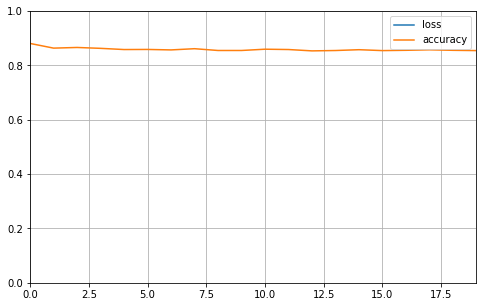

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [45]:
Teste = model.predict(compasses_array)

In [46]:
Index_musica = 9
A = Teste[Index_musica][0]
B = Teste[Index_musica][1]
C = Teste[Index_musica][2]
D = Teste[Index_musica][3]
E = Teste[Index_musica][4]
F = Teste[Index_musica][5]
G = Teste[Index_musica][6]
H = Teste[Index_musica][7]
I = Teste[Index_musica][8]
J = Teste[Index_musica][9]
Musica_1 = np.concatenate((A,B,C,D,E,F,G,H,I,J),axis=0)
Musica_1_floor = np.floor(Musica_1)*1
Musica_1_around = np.around(Musica_1)

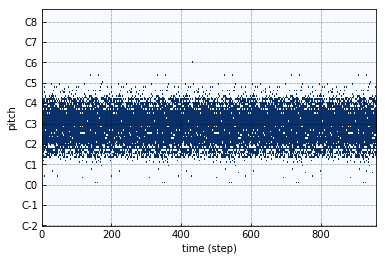

In [47]:
track = Track(pianoroll = Musica_1, program=0, is_drum=False,
              name=' ')

fig = track.plot()
plt.show()

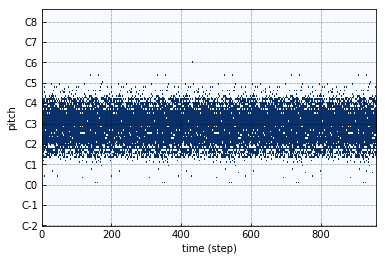

In [48]:
track_floor = Track(pianoroll = Musica_1_floor, program=0, is_drum=False,
              name='Floor')

fig = track_floor.plot()
plt.show()

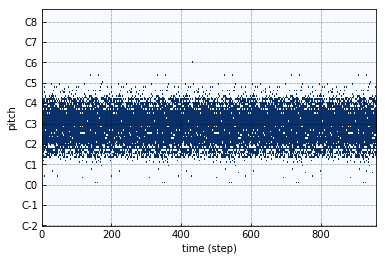

In [49]:
track = Track(pianoroll = Musica_1_around, program=0, is_drum=False,
              name=' ')

fig = track.plot()
plt.show()

In [50]:
Musica_1_floor[5]

array([  -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,  447.,  302.,  260.,
        475.,   -2.,  129.,  232.,  475.,  622.,  751.,   -2.,  350.,
        926.,  355.,  124.,  322.,  513.,   51.,  347.,  353.,  141.,
       1131.,  424.,  308.,  567.,  126.,  600.,  124.,  213.,   -2.,
        531.,   -2.,  250.,  265.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,   -2.,
         -2.,   -2.]

In [51]:
Musica_1[5]

array([  -1.7577227,   -1.7580671,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.758076 ,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.7580743,   -1.6889385,   -1.7580993,
         -1.7580993,   -1.7580986,   -1.3399992,   -1.7580993,
         -1.7580993,   -1.7580993,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.7576714,   -1.7580993,   -1.7580947,
         -1.7580993,   -1.7577299,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.7580993,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.7580993,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.7580993,   -1.7580993,   -1.7580993,
         -1.7580993,   -1.7580993,  447.90344  ,  302.85858  ,
        260.03058  ,  475.9012   ,   -1.7580993,  129.1092   ,
        232.50462  ,  475.13733  ,  622.5438   ,  751.2205   ,
         -1.7580993,  350.43826  ,  926.7822   ,  355.38773  ,
        124.7499   ,  322.03015  ,  513.38245  ,   51.481503 ,
        347.28613  ,  353.50546  ,  141.84627  , 1131.5

(1706, 10, 96, 128)


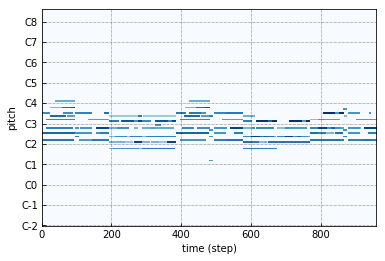

In [39]:
y_test = np.array(compasses_array)
print (y_test.shape)

Real = y_test
A = Real[Index_musica][0]
B = Real[Index_musica][1]
C = Real[Index_musica][2]
D = Real[Index_musica][3]
E = Real[Index_musica][4]
F = Real[Index_musica][5]
G = Real[Index_musica][6]
H = Real[Index_musica][7]
I = Real[Index_musica][8]
J = Real[Index_musica][9]
Musica_2 = np.concatenate((A,B,C,D,E,F,G,H,I,J),axis=0)

track_2 = Track(pianoroll = Musica_2, program=0, is_drum=False,
              name=' ')

fig = track_2.plot()
plt.show()

In [40]:
Real[Index_musica][0][0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  92,   0,
         0,   0, 101,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  82,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [26]:
Write = toPypianoroll(Musica_1_floor, Index_musica, pypianoroll_musics)
Write

Multitrack(tracks=['Guitar'], tempo=array([91.99998773, 91.99998773, 91.99998773, 91.99998773, 91.99998773,
       91.99998773, 91.99998773, 91.99998773, 91.99998773, 91.99998773]), downbeat=array([ True, False, False, False, False, False, False, False, False,
       False]), beat_resolution=24, name=7c2e695d0593d35ca3b0913549754f18)

In [27]:
Realidade = toPypianoroll(Musica_2, Index_musica, pypianoroll_musics)
Realidade.tempo.shape

(10,)

In [28]:
Write.write('D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Brinca_Second')

In [29]:
Realidade.write('D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Brica_Real_Second')